# Master's Thesis Results Analysis

In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [232]:
job_dataset = pd.read_csv('datasets/job_dataset.csv')
same_season_job_dataset = pd.read_csv('datasets/jobs_dataset_same_season.csv')
pool_run_dataset = pd.read_csv('datasets/pool_run_dataset.csv')

In [233]:
job_dataset.created_at = pd.to_datetime(job_dataset.created_at)
pool_run_dataset.started_at = pd.to_datetime(pool_run_dataset.started_at)
same_season_job_dataset.created_at = pd.to_datetime(same_season_job_dataset.created_at)

cut_date = pd.to_datetime("2025-04-01", utc=True)
job_dataset = job_dataset[job_dataset.created_at >= cut_date]
pool_run_dataset = pool_run_dataset[pool_run_dataset.started_at >= cut_date]

### Cancellation Rate Analysis

For the cancellation rate analysis, a non-parametric test will be used due to the dataset's characteristics.
A parametric test assumes normality of the dataset, therefore a non-parametric test will be used in this analysis to avoid normality testing without affecting the final results.

In [234]:
cut_date = pd.to_datetime("2025-06-13", utc=True)
before_dataset = job_dataset[job_dataset.created_at < cut_date]
after_dataset = job_dataset[job_dataset.created_at > cut_date]

In [235]:
contingency_table = [
    [before_dataset.canceled_by_us.value_counts()[1], before_dataset.canceled_by_us.value_counts()[0]],
    [after_dataset.canceled_by_us.value_counts()[1], after_dataset.canceled_by_us.value_counts()[0]]
]

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 703.2612633908279
P-value: 5.84148594652336e-155


In [236]:
contingency_table_2 = [
    [same_season_job_dataset.canceled_by_us.value_counts()[1], same_season_job_dataset.canceled_by_us.value_counts()[0]],
    [after_dataset.canceled_by_us.value_counts()[1], after_dataset.canceled_by_us.value_counts()[0]]
]

chi2, p, dof, expected = stats.chi2_contingency(contingency_table_2)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 164.34964158766303
P-value: 1.2687644306362663e-37


The null hypothesis for the chi-square test of independence is that there is no association between the time period (before vs. after the cut-off date) and the cancellation rate.

Given the very small p-values (p < 0.05), we reject the null hypothesis. This indicates that there is a statistically significant association between the time period and the cancellation rate.

In [237]:
before_canceled_by_us_rate = before_dataset.groupby([pd.Grouper(key='created_at', freq='D')])['canceled_by_us'].sum() / before_dataset.groupby([pd.Grouper(key='created_at', freq='D')])['canceled_by_us'].count()
after_canceled_by_us_rate = after_dataset.groupby([pd.Grouper(key='created_at', freq='D')])['canceled_by_us'].sum() / after_dataset.groupby([pd.Grouper(key='created_at', freq='D')])['canceled_by_us'].count()
same_season_canceled_by_us_rate = same_season_job_dataset.groupby([pd.Grouper(key='created_at', freq='D')])['canceled_by_us'].sum() / same_season_job_dataset.groupby([pd.Grouper(key='created_at', freq='D')])['canceled_by_us'].count()

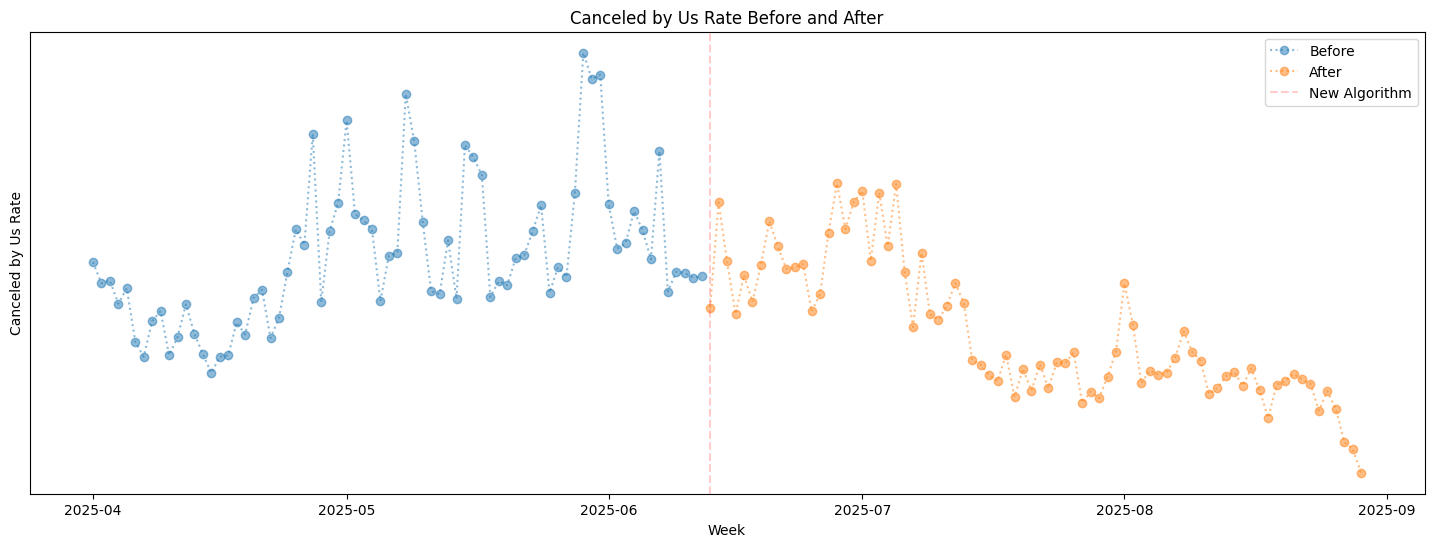

In [238]:
plt.figure(figsize=(18, 6))
plt.plot(before_canceled_by_us_rate.index, before_canceled_by_us_rate.values, label='Before', alpha=0.5, linestyle='dotted', marker='o')
plt.plot(after_canceled_by_us_rate.index, after_canceled_by_us_rate.values, label='After', alpha=0.5, linestyle='dotted', marker='o')
# Add a vertical line to indicate the change point
plt.axvline(x=cut_date, color='red', linestyle='--', label='New Algorithm', alpha=0.2)

plt.title('Canceled by Us Rate Before and After')
plt.xlabel('Week')
plt.ylabel('Canceled by Us Rate')
plt.yticks([])
plt.legend()
plt.show()


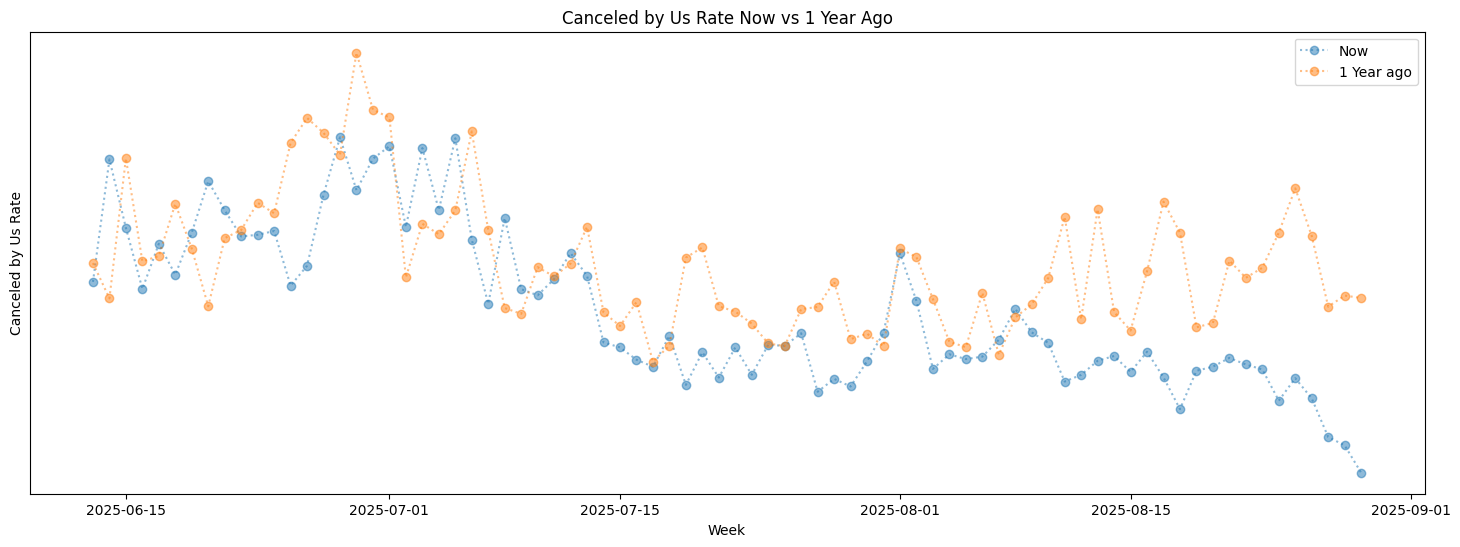

In [239]:
# Same Season Canceled by Us Rate Overlapped with Before and After
plt.figure(figsize=(18, 6))
plt.plot(after_canceled_by_us_rate.index, after_canceled_by_us_rate.values, label='Now', alpha=0.5, linestyle='dotted', marker='o')
plt.plot(after_canceled_by_us_rate.index, same_season_canceled_by_us_rate.values, label='1 Year ago', alpha=0.5, linestyle='dotted', marker='o')

plt.title('Canceled by Us Rate Now vs 1 Year Ago')
plt.xlabel('Week')
plt.ylabel('Canceled by Us Rate')
plt.yticks([])
plt.legend()
plt.show()


In [240]:
# Since the time between the before and after datasets, we align the datasets
min_length = min(len(after_canceled_by_us_rate), len(before_canceled_by_us_rate))
after_canceled_by_us_rate = after_canceled_by_us_rate.iloc[:min_length]
before_canceled_by_us_rate = before_canceled_by_us_rate.iloc[:min_length]

before_and_after_canceled_by_us_difference = after_canceled_by_us_rate.values - before_canceled_by_us_rate.values

before_and_after_canceled_by_us_difference = before_and_after_canceled_by_us_difference / before_canceled_by_us_rate.values

canceled_by_us_rate_difference = (before_and_after_canceled_by_us_difference.sum() / len(before_and_after_canceled_by_us_difference)) * 100

print(f"Canceled by Us Rate difference: {canceled_by_us_rate_difference}%")

# Since the time between the before and after datasets, we align the datasets
min_length = min(len(after_canceled_by_us_rate), len(same_season_canceled_by_us_rate))
after_canceled_by_us_rate = after_canceled_by_us_rate.iloc[:min_length]
same_season_canceled_by_us_rate = same_season_canceled_by_us_rate.iloc[:min_length]

same_season_canceled_by_us_difference = after_canceled_by_us_rate.values - same_season_canceled_by_us_rate.values

same_season_canceled_by_us_difference = same_season_canceled_by_us_difference / same_season_canceled_by_us_rate.values

canceled_by_us_rate_difference = (same_season_canceled_by_us_difference.sum() / len(same_season_canceled_by_us_difference)) * 100

print(f"Same season Canceled by Us Rate difference: {canceled_by_us_rate_difference}%")


Canceled by Us Rate difference: -17.90315787988612%
Same season Canceled by Us Rate difference: -16.3773128271592%


### Acceptance Rate Analysis

For the acceptance rate analysis, a non-parametric test will also be used due to the dataset's characteristics.

In [241]:
before_dataset = pool_run_dataset[pool_run_dataset.started_at < cut_date]
after_dataset = pool_run_dataset[pool_run_dataset.started_at > cut_date]

In [242]:
contingency_table = [
    [before_dataset.accepted.value_counts()[1], before_dataset.accepted.value_counts()[0]],
    [after_dataset.accepted.value_counts()[1], after_dataset.accepted.value_counts()[0]]
]

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 382.9756930179052
P-value: 2.799707589358263e-85


The null hypothesis (H₀) for the chi-square test of independence is that there is no association between the time period and the acceptance rate.

With the resulting p-value, which is a lot smaller than the common significance level of 0.05, we reject the null hypothesis. This indicates that there is a statistically significant association between the time period (before and after the algorithm change) and the job acceptance rate.

In [243]:
before_acceptance_rate = before_dataset.groupby([pd.Grouper(key='started_at', freq='D')])['accepted'].sum() / before_dataset.groupby([pd.Grouper(key='started_at', freq='D')])['accepted'].count()
after_acceptance_rate = after_dataset.groupby([pd.Grouper(key='started_at', freq='D')])['accepted'].sum() / after_dataset.groupby([pd.Grouper(key='started_at', freq='D')])['accepted'].count()

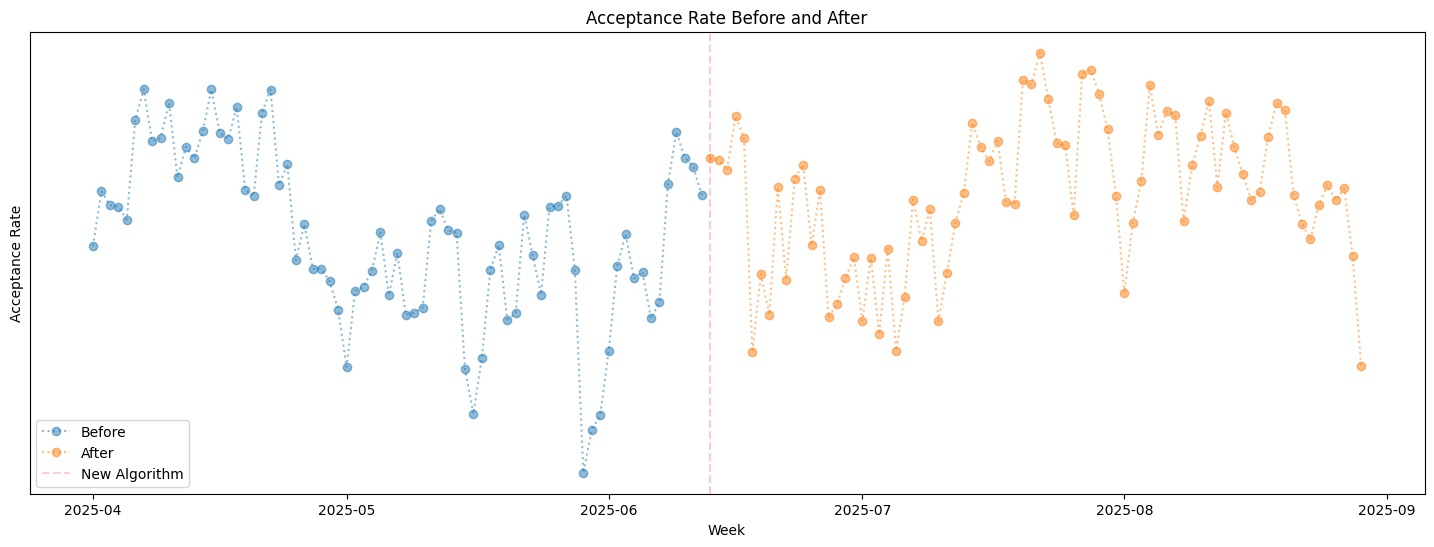

In [244]:
plt.figure(figsize=(18, 6))
plt.plot(before_acceptance_rate.index, before_acceptance_rate.values, label='Before', alpha=0.5, linestyle='dotted', marker='o')
plt.plot(after_acceptance_rate.index, after_acceptance_rate.values, label='After', alpha=0.5, linestyle='dotted', marker='o')
# Add a vertical line to indicate the change point
plt.axvline(x=cut_date, color='red', linestyle='--', label='New Algorithm', alpha=0.2)

plt.title('Acceptance Rate Before and After')
plt.xlabel('Week')
plt.ylabel('Acceptance Rate')
plt.yticks([])
plt.legend()
plt.show()

In [245]:
# Since the time between the before and after datasets, we align the datasets
min_length = min(len(after_acceptance_rate), len(before_acceptance_rate))
after_acceptance_rate = after_acceptance_rate.iloc[:min_length]
before_acceptance_rate = before_acceptance_rate.iloc[:min_length]

before_and_after_acceptance_difference = after_acceptance_rate.values - before_acceptance_rate.values

before_and_after_acceptance_difference = before_and_after_acceptance_difference / before_acceptance_rate.values

acceptance_rate_difference = (before_and_after_acceptance_difference.sum() / len(before_and_after_acceptance_difference)) * 100

print(f"Acceptance Rate improvement: {acceptance_rate_difference}%")

Acceptance Rate improvement: 15.363161944914715%


In [273]:
# Levene's test for equality of variances
statistic, p_value = stats.levene(before_acceptance_rate, after_acceptance_rate)

print(f"Levene's test statistic: {statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The p-value is less than 0.05, so we reject the null hypothesis.")
    print("This suggests that the variances are significantly different.")
else:
    print("The p-value is not less than 0.05, so we cannot reject the null hypothesis.")
    print("This suggests that there is no significant difference in the variances.")

Levene's test statistic: 1.0098499731728103
P-value: 0.3166244263237593
The p-value is not less than 0.05, so we cannot reject the null hypothesis.
This suggests that there is no significant difference in the variances.


### Average pool time

In [246]:
# Direct before and after comparison
res = stats.mannwhitneyu(before_dataset.runtime_in_sec, after_dataset.runtime_in_sec)

print("Before vs After")
print(f"U statistic: {res.statistic}")
print(f"P-value: {res.pvalue}")

Before vs After
U statistic: 1708200542.0
P-value: 0.0


In [247]:
before_average_pool_time = before_dataset.groupby([pd.Grouper(key='started_at', freq='D')])['runtime_in_sec'].sum() / before_dataset.groupby([pd.Grouper(key='started_at', freq='D')])['runtime_in_sec'].count()
after_average_pool_time = after_dataset.groupby([pd.Grouper(key='started_at', freq='D')])['runtime_in_sec'].sum() / after_dataset.groupby([pd.Grouper(key='started_at', freq='D')])['runtime_in_sec'].count()

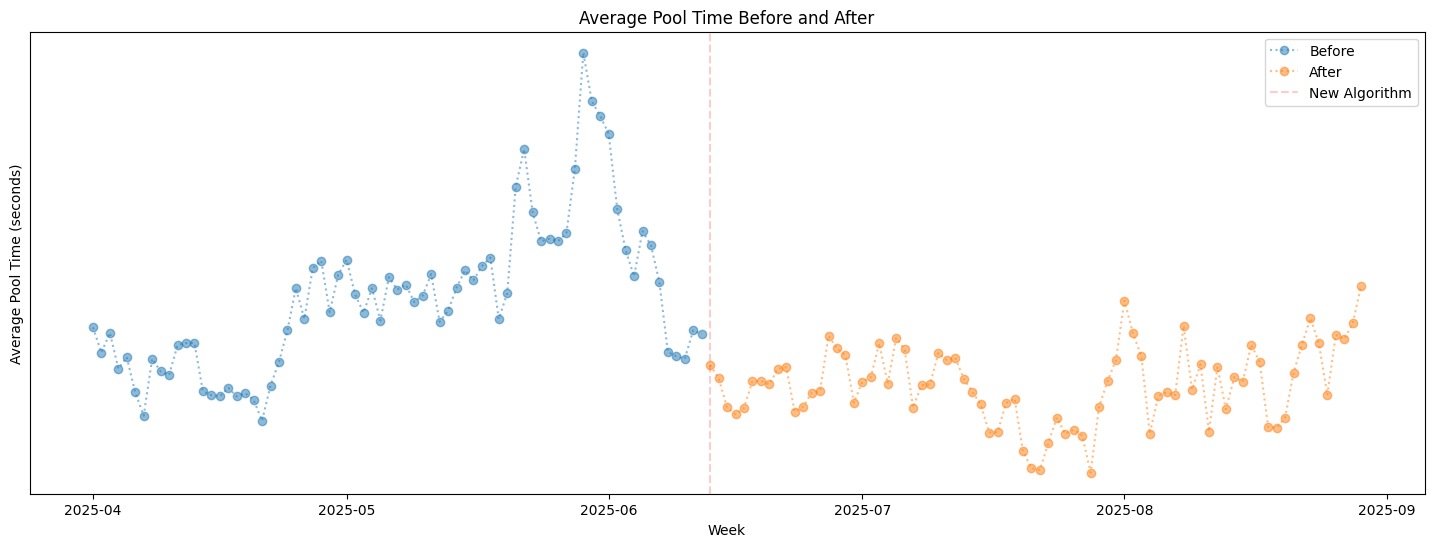

In [248]:
plt.figure(figsize=(18, 6))
plt.plot(before_average_pool_time.index, before_average_pool_time.values, label='Before', alpha=0.5, linestyle='dotted', marker='o')
plt.plot(after_average_pool_time.index, after_average_pool_time.values, label='After', alpha=0.5, linestyle='dotted', marker='o')
# Add a vertical line to indicate the change point
plt.axvline(x=cut_date, color='red', linestyle='--', label='New Algorithm', alpha=0.2)

plt.title('Average Pool Time Before and After')
plt.xlabel('Week')
plt.ylabel('Average Pool Time (seconds)')
plt.yticks([])
plt.legend()
plt.show()

In [ ]:
# Since the time between the before and after datasets, we align the datasets
min_length = min(len(after_average_pool_time), len(before_average_pool_time))
after_average_pool_time = after_average_pool_time.iloc[:min_length]
before_average_pool_time = before_average_pool_time.iloc[:min_length]

pool_time_difference = after_average_pool_time.values - before_average_pool_time.values

before_and_after_pool_time_difference = pool_time_difference / before_average_pool_time.values

pool_time_difference = (before_and_after_pool_time_difference.sum() / len(before_and_after_pool_time_difference)) * 100

print(f"Pool Time improvement: {pool_time_difference}%")

Pool Time improvement: -18.52695736775865%


In [249]:
before_dataset_only_accepted = before_dataset[before_dataset['accepted'] == 1]
after_dataset_only_accepted = after_dataset[after_dataset['accepted'] == 1]

In [250]:
# Direct before and after comparison
res = stats.mannwhitneyu(before_dataset_only_accepted.runtime_in_sec, after_dataset_only_accepted.runtime_in_sec)

print("Time to accept")
print("Before vs After")
print(f"U statistic: {res.statistic}")
print(f"P-value: {res.pvalue}")

Time to accept
Before vs After
U statistic: 483065838.0
P-value: 5.123008415648823e-281


In [251]:
before_average_pool_time_to_accept = before_dataset_only_accepted.groupby([pd.Grouper(key='started_at', freq='D')])['runtime_in_sec'].sum() / before_dataset_only_accepted.groupby([pd.Grouper(key='started_at', freq='D')])['runtime_in_sec'].count()
after_average_pool_time_to_accept = after_dataset_only_accepted.groupby([pd.Grouper(key='started_at', freq='D')])['runtime_in_sec'].sum() / after_dataset_only_accepted.groupby([pd.Grouper(key='started_at', freq='D')])['runtime_in_sec'].count()

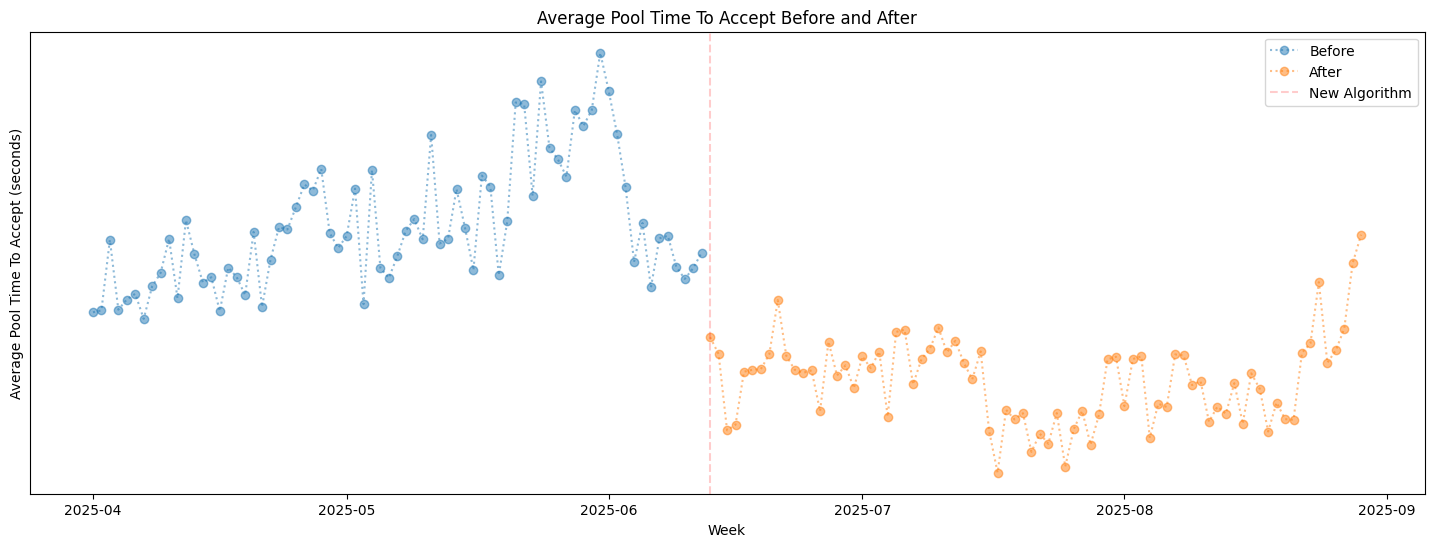

In [252]:
plt.figure(figsize=(18, 6))
plt.plot(before_average_pool_time_to_accept.index, before_average_pool_time_to_accept.values, label='Before', alpha=0.5, linestyle='dotted', marker='o')
plt.plot(after_average_pool_time_to_accept.index, after_average_pool_time_to_accept.values, label='After', alpha=0.5, linestyle='dotted', marker='o')
# Add a vertical line to indicate the change point
plt.axvline(x=cut_date, color='red', linestyle='--', label='New Algorithm', alpha=0.2)

plt.title('Average Pool Time To Accept Before and After')
plt.xlabel('Week')
plt.ylabel('Average Pool Time To Accept (seconds)')
plt.yticks([])
plt.legend()
plt.show()

In [277]:
# Since the time between the before and after datasets, we align the datasets
min_length = min(len(after_average_pool_time_to_accept), len(before_average_pool_time_to_accept))
after_average_pool_time_to_accept = after_average_pool_time_to_accept.iloc[:min_length]
before_average_pool_time_to_accept = before_average_pool_time_to_accept.iloc[:min_length]

pool_time_difference = after_average_pool_time_to_accept.values - before_average_pool_time_to_accept.values

before_and_after_pool_time_to_accept_difference = pool_time_difference / before_average_pool_time_to_accept.values

pool_time_difference = (before_and_after_pool_time_to_accept_difference.sum() / len(before_and_after_pool_time_to_accept_difference)) * 100

print(f"Pool Time improvement: {pool_time_difference}%")

Pool Time improvement: -26.12315706535771%


### Average Service Rating Analysis

To determine the average rating, first the NaN values must be removed from the dataset

In [256]:
dataset_without_nan = job_dataset.dropna(axis=0, how='any', inplace=False)
same_season_job_dataset_without_nan = same_season_job_dataset.dropna(axis=0, how='any', inplace=False)

In [257]:
before_dataset = dataset_without_nan[dataset_without_nan.created_at < cut_date]
after_dataset = dataset_without_nan[dataset_without_nan.created_at > cut_date]

For the average rating, a Mann–Whitney–Wilcoxon test, also known as the Wilcoxon rank-sum test, will be used due to the data not being binary but continuous.w

In [258]:
# Direct before and after comparison
res = stats.mannwhitneyu(before_dataset.rating, after_dataset.rating)

print("Before vs After")
print(f"U statistic: {res.statistic}")
print(f"P-value: {res.pvalue}")

# 1 Year ago vs Now
res = stats.mannwhitneyu(same_season_job_dataset_without_nan.rating, dataset_without_nan.rating)

print("1 Year ago vs Now")
print(f"U statistic: {res.statistic}")
print(f"P-value: {res.pvalue}")


Before vs After
U statistic: 256865832.0
P-value: 0.1581343121055363
1 Year ago vs Now
U statistic: 307920200.0
P-value: 2.080488920635629e-45


In [259]:
before_average_rating = before_dataset.groupby([pd.Grouper(key='created_at', freq='D')])['rating'].sum() / before_dataset.groupby([pd.Grouper(key='created_at', freq='D')])['rating'].count()
after_average_rating = after_dataset.groupby([pd.Grouper(key='created_at', freq='D')])['rating'].sum() / after_dataset.groupby([pd.Grouper(key='created_at', freq='D')])['rating'].count()
same_season_average_rating = same_season_job_dataset_without_nan.groupby([pd.Grouper(key='created_at', freq='D')])['rating'].sum() / same_season_job_dataset_without_nan.groupby([pd.Grouper(key='created_at', freq='D')])['rating'].count()

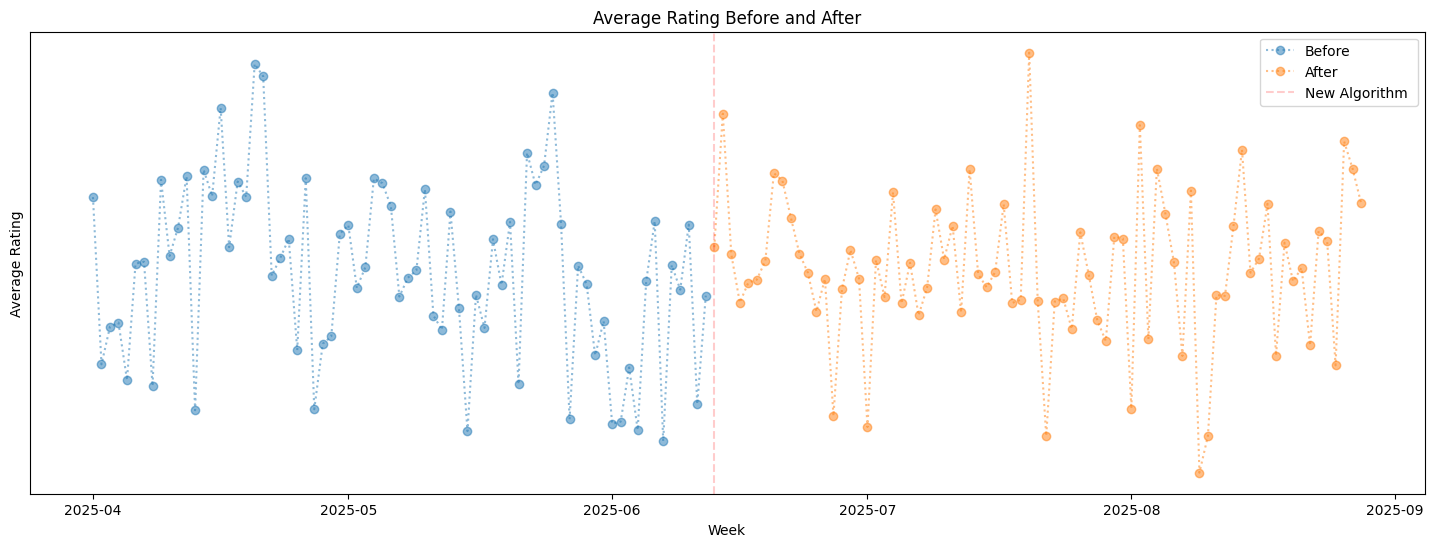

In [261]:
plt.figure(figsize=(18, 6))
plt.plot(before_average_rating.index, before_average_rating.values, label='Before', alpha=0.5, linestyle='dotted', marker='o')
plt.plot(after_average_rating.index, after_average_rating.values, label='After', alpha=0.5, linestyle='dotted', marker='o')
# Add a vertical line to indicate the change point
plt.axvline(x=cut_date, color='red', linestyle='--', label='New Algorithm ', alpha=0.2)

plt.title('Average Rating Before and After')
plt.xlabel('Week')
plt.ylabel('Average Rating')
plt.yticks([])
plt.legend()
plt.show()

In [260]:
print("Before vs After")
print(f"Variance: {before_average_rating.var()} vs {after_average_rating.var()}")

Before vs After
Variance: 0.004263858796011488 vs 0.003049410211290489


In [ ]:
# Levene's test for equality of variances
statistic, p_value = stats.levene(before_average_rating, after_average_rating)

print(f"Levene's test statistic: {statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The p-value is less than 0.05, so we reject the null hypothesis.")
    print("This suggests that the variances are significantly different.")
else:
    print("The p-value is not less than 0.05, so we cannot reject the null hypothesis.")
    print("This suggests that there is no significant difference in the variances.")

Levene's test statistic: 4.696076895670561
P-value: 0.03187599243461231
The p-value is less than 0.05, so we reject the null hypothesis.
This suggests that the variances are significantly different.


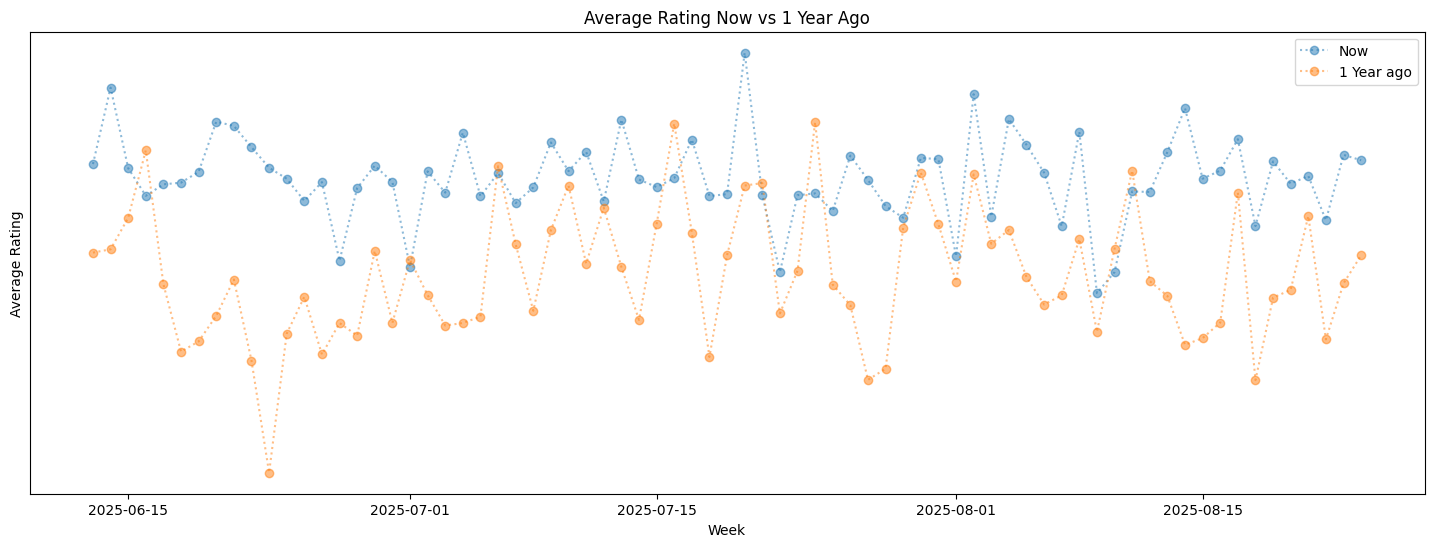

In [267]:
# Same Season Average Rating Overlapped with Before and After
plt.figure(figsize=(18, 6))

# Since the time between the before and after datasets, we align the datasets
min_length = min(len(after_average_rating), len(same_season_average_rating))
after_average_rating = after_average_rating.iloc[:min_length]
same_season_average_rating = same_season_average_rating.iloc[:min_length]

plt.plot(after_average_rating.index, after_average_rating.values, label='Now', alpha=0.5, linestyle='dotted', marker='o')
plt.plot(after_average_rating.index, same_season_average_rating.values, label='1 Year ago', alpha=0.5, linestyle='dotted', marker='o')

plt.title('Average Rating Now vs 1 Year Ago')
plt.xlabel('Week')
plt.ylabel('Average Rating')
plt.yticks([])
plt.legend()
plt.show()

In [268]:
# Since the time between the before and after datasets, we align the datasets
min_length = min(len(after_average_rating), len(before_average_rating))
after_average_rating = after_average_rating.iloc[:min_length]
before_average_rating = before_average_rating.iloc[:min_length]

before_and_after_average_rating_difference = after_average_rating.values - before_average_rating.values

before_and_after_average_rating_difference = before_and_after_average_rating_difference / before_average_rating.values

average_rating_difference = (before_and_after_average_rating_difference.sum() / len(before_and_after_average_rating_difference)) * 100

print(f"Average rating difference: {average_rating_difference}%")

same_season_average_rating_difference = after_average_rating.values - same_season_average_rating.values

same_season_average_rating_difference = same_season_average_rating_difference / same_season_average_rating.values

average_rating_difference = (same_season_average_rating_difference.sum() / len(same_season_average_rating_difference)) * 100

print(f"Same season average rating difference: {average_rating_difference}%")


Average rating difference: 0.03558868078410209%
Same season average rating difference: 2.7708215309508866%


In [271]:
print("Before vs After")
print(f"Variance: {same_season_average_rating.var()} vs {after_average_rating.var()}")

Before vs After
Variance: 0.007025732296088397 vs 0.0029245839346126045


In [272]:
# Levene's test for equality of variances
statistic, p_value = stats.levene(same_season_average_rating, after_average_rating)

print(f"Levene's test statistic: {statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The p-value is less than 0.05, so we reject the null hypothesis.")
    print("This suggests that the variances are significantly different.")
else:
    print("The p-value is not less than 0.05, so we cannot reject the null hypothesis.")
    print("This suggests that there is no significant difference in the variances.")

Levene's test statistic: 14.004851579556654
P-value: 0.0002627267896523776
The p-value is less than 0.05, so we reject the null hypothesis.
This suggests that the variances are significantly different.
